In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Transformations to apply on dataset


In [2]:
#applying random flipping, rotation of -90 to +90, cropping
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(), #converting to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalization
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
train_dataset = CIFAR10(root='./data', train=True, download=False, transform=train_transform) # loading dataset
# set download to True if dataset is not downloaded

train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

val_dataset.dataset.transform = test_transform
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True) # pin_memory=True speeds up process on gpu
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True) # num_workers parallelizes process
test_dataset = CIFAR10(root='./data', train=False, download=False, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

Visualizing dataset

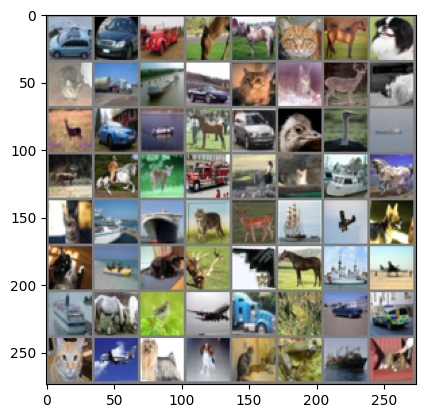

In [4]:
import matplotlib.pyplot as plt
import numpy as np
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = torchvision.utils.make_grid(images)
images = images/2 + 0.5 #reverting normalization
images = images.numpy()
plt.imshow(np.transpose(images, (1, 2, 0)))
plt.show()

Creating ANN model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.ann = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 3, 4000),
            nn.ReLU(),
            nn.Linear(4000, 500),
            nn.Linear(500, 2000),
            nn.ReLU(),
            nn.Linear(2000, 10)
        )
    def forward(self, x):
        return self.ann(x)

In [6]:
model = ANN().to(device)

In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
#function to calculate accuracy on given data
def calculate_accuracy(data):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    return correct / total * 100

Training the Model

In [9]:
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []
for epoch in range(10):
    train_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    train_accuracy = calculate_accuracy(train_loader)
    val_accuracy = calculate_accuracy(val_loader)
    train_accuracy_history.append(train_accuracy)
    val_accuracy_history.append(val_accuracy)

    model.eval() # set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            v_loss = criterion(outputs, labels)
            val_loss += v_loss.item()
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    model.train() # set the model to training mode
    print(f'epoch {epoch+1}: val loss {avg_val_loss: .4f}, train loss {avg_train_loss:.4f}, val_accuracy {val_accuracy:.4f}, train_accuracy {train_accuracy:.4f}')
print('Finished Training')

epoch 1: val loss  1.8845, train loss 2.0818, val_accuracy 33.9200, train_accuracy 33.9625
epoch 2: val loss  1.7148, train loss 1.7875, val_accuracy 39.4500, train_accuracy 39.7175
epoch 3: val loss  1.6175, train loss 1.6509, val_accuracy 43.2700, train_accuracy 43.8125
epoch 4: val loss  1.5599, train loss 1.5603, val_accuracy 45.0100, train_accuracy 46.9400
epoch 5: val loss  1.5060, train loss 1.4816, val_accuracy 47.2000, train_accuracy 49.3975
epoch 6: val loss  1.4642, train loss 1.4110, val_accuracy 48.2400, train_accuracy 51.9725
epoch 7: val loss  1.4148, train loss 1.3458, val_accuracy 50.4000, train_accuracy 54.9725
epoch 8: val loss  1.3966, train loss 1.2843, val_accuracy 51.2900, train_accuracy 57.2875
epoch 9: val loss  1.3796, train loss 1.2273, val_accuracy 51.9100, train_accuracy 59.1025
epoch 10: val loss  1.3674, train loss 1.1697, val_accuracy 52.4000, train_accuracy 62.1725
Finished Training


In [10]:
test_accuracy = calculate_accuracy(test_loader)
print(f'test accuracy {test_accuracy:.4f}')

test accuracy 52.8500


In [11]:
prediction = []
label = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        prediction.extend(predicted.cpu().numpy())
        label.extend(labels.cpu().numpy())

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(label, prediction, average='macro')
recall = recall_score(label, prediction, average='macro')
f1 = f1_score(label, prediction, average='macro')

print(f'Precision: {precision: .4f}, recall: {recall: .4f}, F1 score: {f1:.4f}')

Precision:  0.5257, recall:  0.5285, F1 score: 0.5242


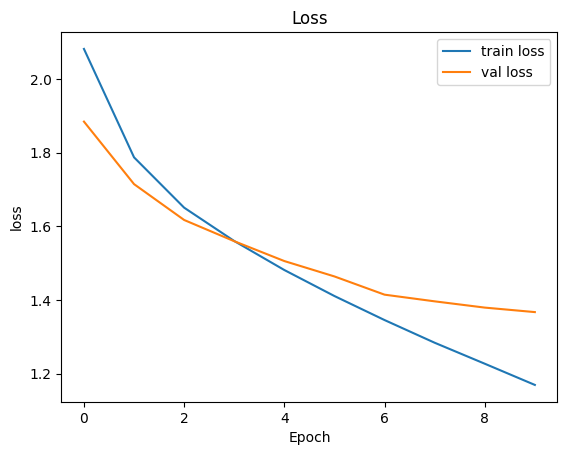

In [13]:
plt.plot(train_loss_history, label='train loss')
plt.plot(val_loss_history, label='val loss')
plt.legend(loc='best')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

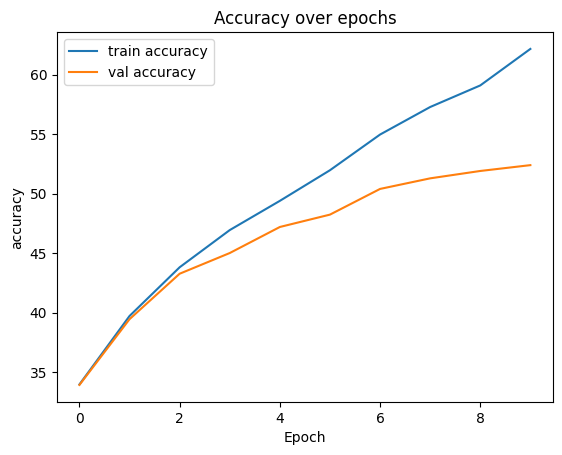

In [14]:
plt.plot(train_accuracy_history, label='train accuracy')
plt.plot(val_accuracy_history, label='val accuracy')
plt.legend(loc='best')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.show()

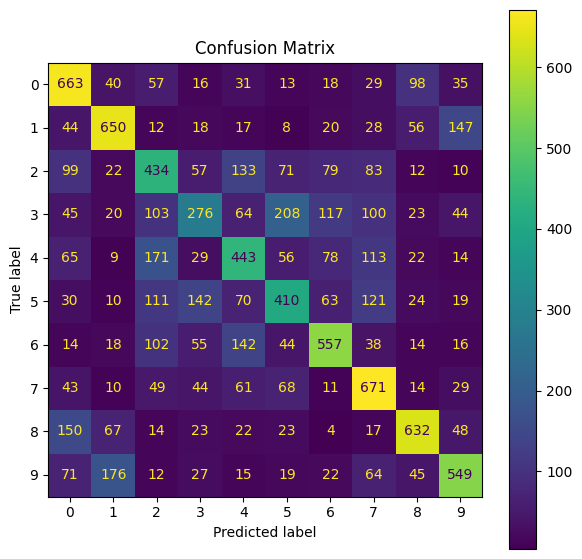

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cfn_matrix = confusion_matrix(label, prediction)
display = ConfusionMatrixDisplay(confusion_matrix=cfn_matrix)

fig, ax = plt.subplots(figsize=(7, 7))
display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('ann_confusion_matrix.png')
plt.show()

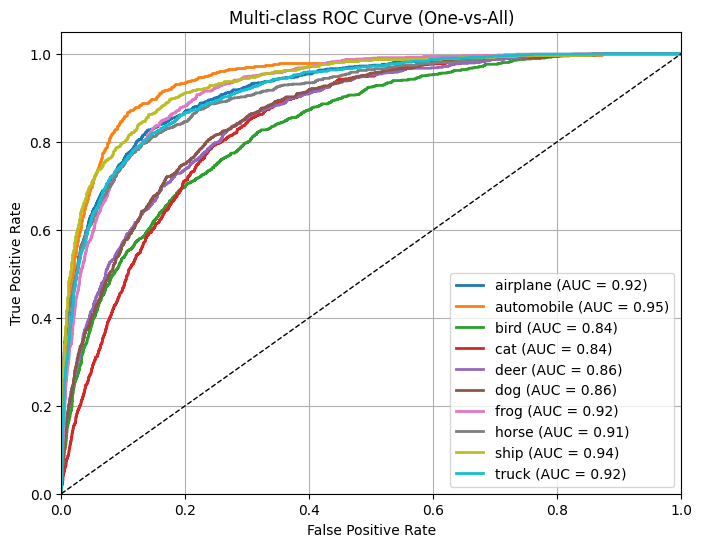

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

n_classes = 10  # CIFAR-10 has 10 classes
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

np_label = np.concatenate(all_labels)
np_prediction = np.concatenate(all_probs)

binary_label = label_binarize(np_label, classes=np.arange(10))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(binary_label[:, i], np_prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8, 6))

for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{test_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-All)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('ann_roc_curve.png')
plt.show()
